# **Progetto Industy Lab**: *Data Exploration & Preparation*

Mario Pedol (830296), Nabil ElAsri (826040)

# 1) Data Exploration

In questo paragrafo si prende confidenza con i dati cercando di capire al meglio possibili andamenti anomali/errati all'interno di essi.

## Set Up

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import scipy
from datetime import datetime, date 
import math
import missingno as mnso
from scipy.stats import boxcox

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, HypothesisTestWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', HypothesisTestWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)


## Utils

In [2]:
def adf_test(col):
    result = adfuller(col)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    print(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}')


def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'

In [3]:
os.chdir("../")
print(os.getcwd())

c:\Users\nabil\Downloads\Progetto_industry


## Descrtive Analysis

Analisi delle statistiche descrittive del data set

Esplorazione delle statistiche descrittive del dataset. Per prima cosa si caricano i dati Originali

In [4]:
df = pd.read_csv('Data/Original/Bacino_idrico.csv')

Viene eliminata l'ultima riga da utilizzare per infarire in fase di deploy. per "inferenced_La" prendo anche le ultime 6 rilevazioni necessarie in seguito per costruire il data "new" di input.

In [5]:
inferenced_LA = df.iloc[-7:]
inferenced_PU = df.iloc[-1825:]
inferenced_LA.to_csv('Data/Inference/infer_LA.csv')
inferenced_PU.to_csv('Data/Inference/infer_PU.csv')

In [6]:
inferenced_LA

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
6379,24/06/2020,0.0,0.0,0.0,0.0,0.0,22.15,29.86,0.6
6380,25/06/2020,0.0,0.0,0.0,0.0,0.0,22.35,29.87,0.6
6381,26/06/2020,0.0,0.0,0.0,0.0,0.0,22.50,29.85,0.6
6382,27/06/2020,0.0,0.0,0.0,0.0,0.0,23.40,29.84,0.6
6383,28/06/2020,0.0,0.0,0.0,0.0,0.0,21.50,29.83,0.6
6384,29/06/2020,0.0,0.0,0.0,0.0,0.0,23.20,29.82,0.6
6385,30/06/2020,0.0,0.0,0.0,0.0,0.0,22.75,29.80,0.6


In [7]:
df=df.iloc[0:-1]

In [8]:
df.columns

Index(['Data', 'Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3',
       'Pioggia_Zona_4', 'Pioggia_Zona_5', 'Temperatura_Zona_5',
       'Livello_Acqua', 'Portata_Uscita'],
      dtype='object')

In [9]:
df.shape

(6385, 9)

In [10]:
print('Starting date is :' , df['Data'].iloc[0],
      '\nEnding Date is : ',df["Data"].iloc[-1])

Starting date is : 06/01/2003 
Ending Date is :  29/06/2020


In [11]:
pd.Series(df.isnull().sum()).rename_axis('features/target').to_frame('Missing Value Count')

,Missing Value Count
features/target,
Data,0
Pioggia_Zona_1,360
Pioggia_Zona_2,360
Pioggia_Zona_3,360
Pioggia_Zona_4,360
Pioggia_Zona_5,360
Temperatura_Zona_5,361
Livello_Acqua,0
Portata_Uscita,0


Il range di valori per le zone di pioggia è coernete con tutte e 5 le zone. La temperatura è dentro a dei limiti plausibili così come i due target.

In [12]:
df.describe()

,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
count,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6024.000000,6385.000000,6385.000000
mean,2.471635,3.341212,2.670506,2.675187,3.130390,14.528777,28.571768,2.784962
std,6.650488,8.903769,7.167155,7.656404,8.025686,6.943797,2.196266,4.098661
min,0.000000,0.000000,0.000000,0.000000,0.000000,-5.350000,22.530000,0.450000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,26.930000,0.600000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,14.500000,29.260000,1.500000
75%,0.800000,1.400000,1.200000,0.600000,1.200000,20.100000,30.430000,3.000000
max,80.600000,110.000000,120.200000,113.600000,88.400000,34.000000,31.760000,74.650000


## Missinig Analysis

Dalla visualizzazione risulta chiato che tutti i valori mancanti si trovano nelle prime righe del dataset.

<AxesSubplot:>

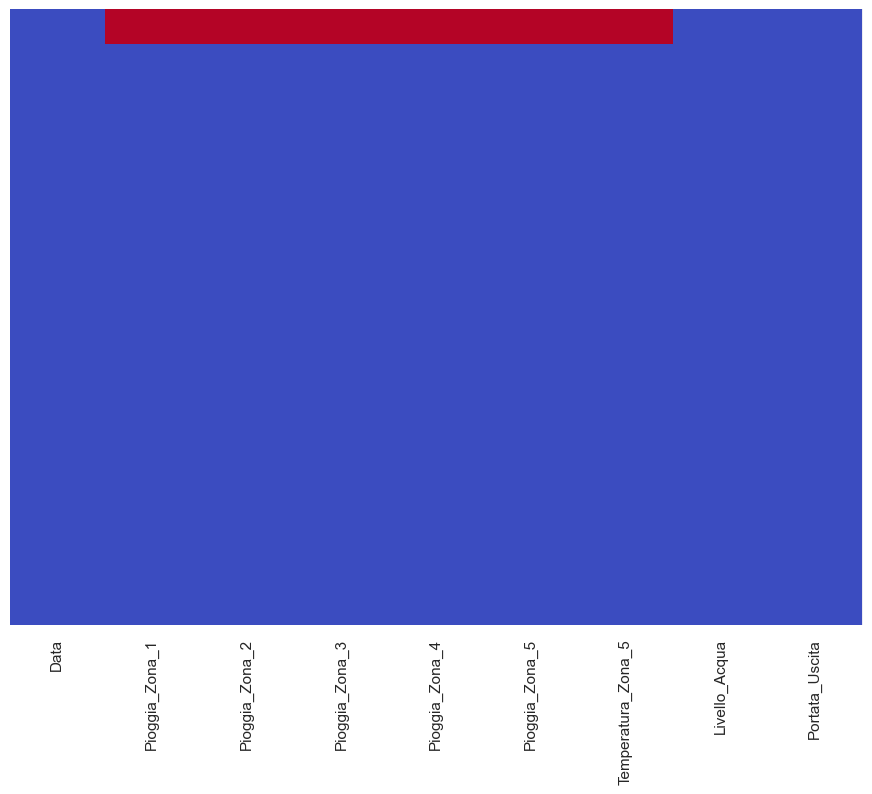

In [13]:
sns.set(rc={'figure.figsize':(11,8)})
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap="coolwarm")

# From this visualisation it is clear the missing data is at top that is old data, so we can drop those.

eliminando tali valori il dataset si riduce di un anno.

In [14]:
df_clean = df.dropna(axis=0)
df_clean.isnull().sum().sum()

0

In [15]:
print('New starting date :' ,      
      df_clean['Data'].iloc[0],
      '\nNew ending Date:',      
      df_clean['Data'].iloc[-1])

New starting date : 02/01/2004 
New ending Date: 29/06/2020


## EDA

Matrice di autocorreleazione delle variabili del dataset

<Figure size 1000x500 with 0 Axes>

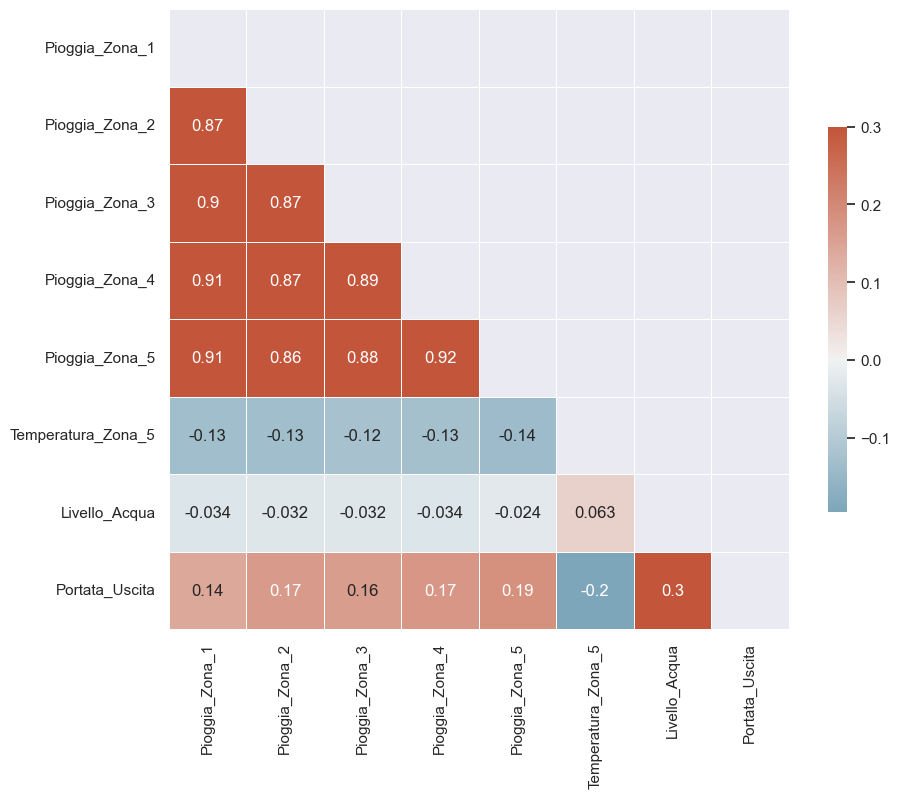

In [16]:
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), mask = mask, annot=True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

Check per vedere se la continuità temporale giornaliera è garantita in tutte le righe del dataset.

In [17]:
df['Data'] = pd.to_datetime(df['Data'], format = '%d/%m/%Y')
df = df.sort_values(by='Data')
df['Diff'] = df['Data'] - df['Data'].shift(1)
df['Diff'].value_counts()

1 days    6384
Name: Diff, dtype: int64

In [18]:
df = df.drop('Diff', axis=1)

In [19]:
df.columns

Index(['Data', 'Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3',
       'Pioggia_Zona_4', 'Pioggia_Zona_5', 'Temperatura_Zona_5',
       'Livello_Acqua', 'Portata_Uscita'],
      dtype='object')

In [20]:
feature_list = ['Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3',
       'Pioggia_Zona_4', 'Pioggia_Zona_5', 'Temperatura_Zona_5']

df.set_index('Data', inplace=True)

Si visulizzano gli andamenti delle variabili esplicative.

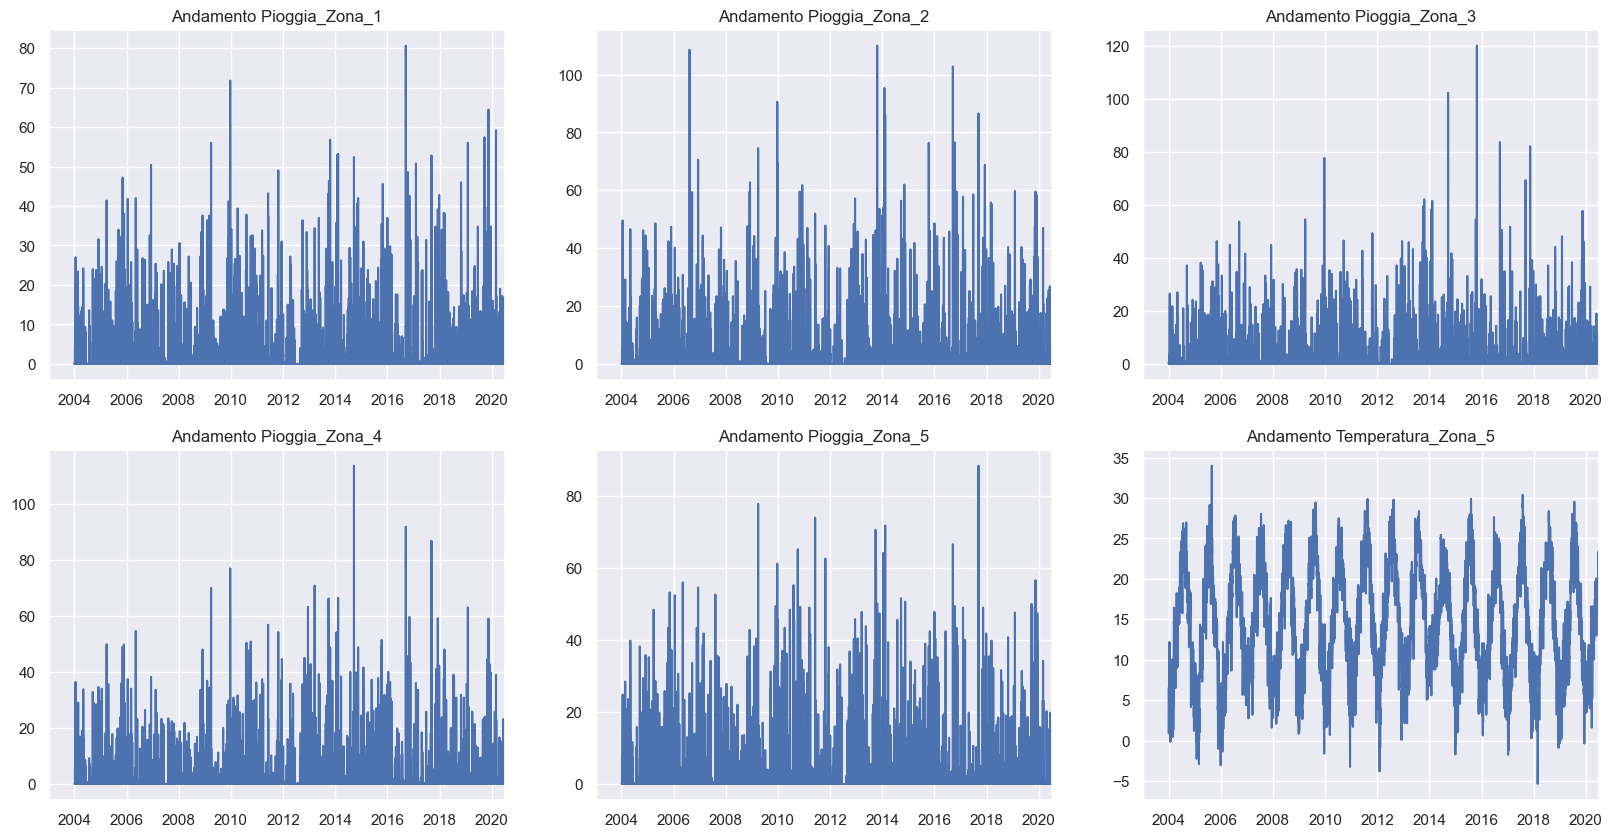

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=3)
count=0
for r in range(2):
    for c in range(3):
        ax = df[feature_list[count]].plot(ax=axes[r,c],figsize=(20, 10), title='Andamento '+feature_list[count])
        ax.set(xlabel='', ylabel='')
        count+=1

E dei due Target.

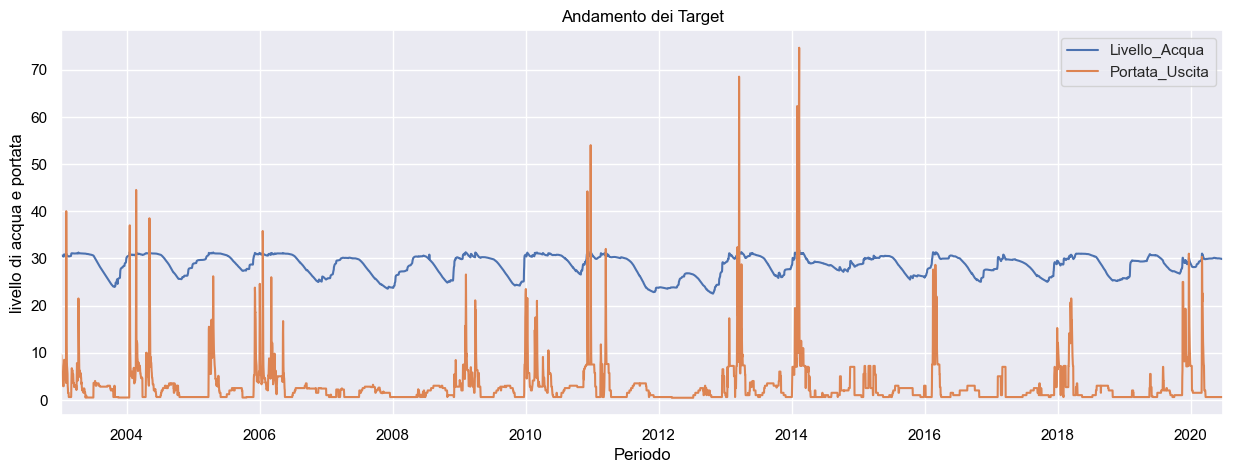

In [22]:
title='Andamento dei Target'
ylabel='livello di acqua e portata'
xlabel='Periodo'

ax = df[['Livello_Acqua', 'Portata_Uscita']].plot(figsize=(15, 5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.label.set_color('black')
ax.xaxis.label.set_color('black')
ax.title.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.yaxis.grid(True)
ax.xaxis.grid(True)
fig=ax.get_figure()


Si costruiscono altre feature di base utili, come Giorni della settimana, Mese, Anno e satgioni.

In [23]:
dfcopy=df.reset_index()
dfcopy['Data'] = pd.to_datetime(dfcopy['Data'], format="%d/%m/%Y")
dfcopy['season'] = dfcopy.Data.map(season_of_date)
dfcopy['weekday'] = dfcopy['Data'].dt.dayofweek

c:\Users\nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\base.py:880: UserWarning: Parsing '21/03/2003' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  new_values = map_f(values, mapper)
c:\Users\nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\base.py:880: UserWarning: Parsing '20/06/2003' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  new_values = map_f(values, mapper)
c:\Users\nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\base.py:880: UserWarning: Parsing '21/06/2003' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  new_values = map_f(values, mapper)
c:\Users\nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\base.py:880: UserWarning: Parsing '22/09/2003' in DD/MM/YYYY format. Provide format or specify infer_datetime_f

In [24]:
dfcopy['Month'] = dfcopy['Data'].dt.month

In [25]:
dfcopy['Year'] = dfcopy['Data'].dt.year

Le piogge non sembrano avere nessuna dipendenza dal giorno della settimana

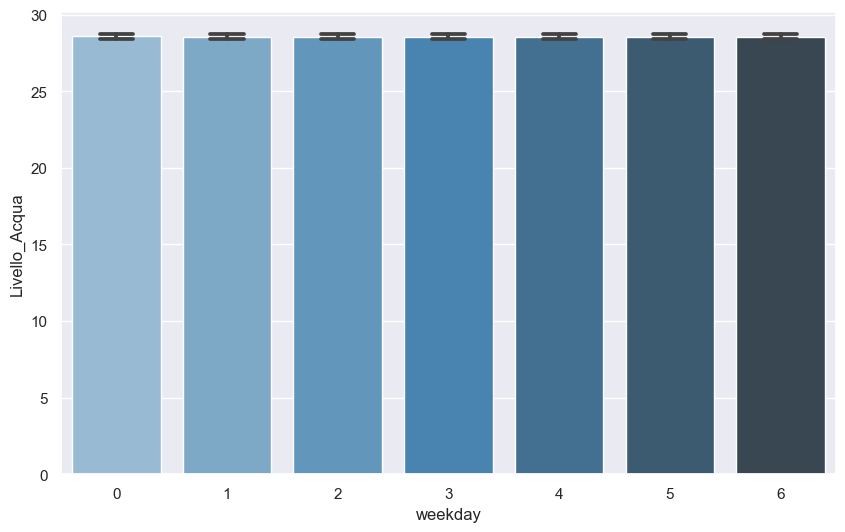

In [26]:
fig = plt.figure(figsize=(10,6))
sns.barplot(x='weekday', y='Livello_Acqua', data=dfcopy, capsize=.3 ,palette="Blues_d")
plt.show()

Invece è possbili notare differenze più marcate per le stagioni.

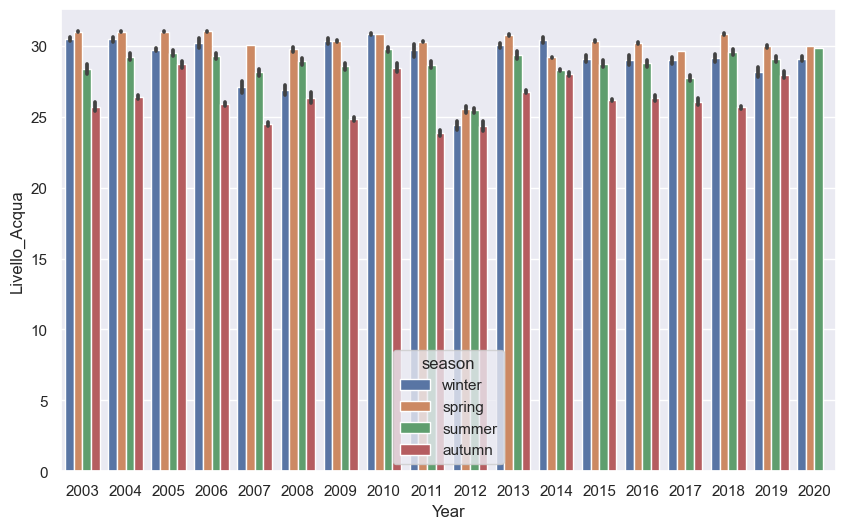

In [27]:
fig = plt.figure(figsize=(10,6))
sns.barplot(x='Year', y='Livello_Acqua', hue="season", data=dfcopy)
plt.show()

# 2) Preprocessing Target 1: **Livello Acqua**.

L'obiettivo di questa sezione è preparare i dati al meglio per poter inferire  il "*Livello_Acqua*", primo target del task. 

### 2.2) Supervised Learning Preprocessing 

Si utilizza per il preprocessing il dataset pulito nella fase di missing analysis

In [28]:
df_xg = df_clean 
df_xg.shape

(6024, 9)

Si costuriscono nuove feature:

- Stagioni: 4 Varibili Dummy;
- Mediana della pioggia;
- Std della pioggia.

In [29]:
df_xg['Data'] = pd.to_datetime(df_xg['Data'], format="%d/%m/%Y")
df_xg['season'] = df_xg.Data.map(season_of_date)

c:\Users\nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\base.py:880: UserWarning: Parsing '21/03/2004' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  new_values = map_f(values, mapper)
c:\Users\nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\base.py:880: UserWarning: Parsing '20/06/2004' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  new_values = map_f(values, mapper)
c:\Users\nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\base.py:880: UserWarning: Parsing '21/06/2004' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  new_values = map_f(values, mapper)
c:\Users\nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\base.py:880: UserWarning: Parsing '22/09/2004' in DD/MM/YYYY format. Provide format or specify infer_datetime_f

In [30]:
seas = pd.get_dummies(df_xg['season'])
df_xg = pd.concat([df_xg,seas], axis=1)
df_xg.drop('season', axis=1, inplace=True)
df_xg['month'] = df_xg['Data'].dt.month
df_xg['year'] = df_xg['Data'].dt.year
df_xg['Pioggia_mediana'] = df_xg[['Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3',
       'Pioggia_Zona_4', 'Pioggia_Zona_5']].median(axis = 1)
df_xg['Pioggia_std'] = df_xg[['Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3',
       'Pioggia_Zona_4', 'Pioggia_Zona_5']].std(axis = 1)
df_xg.head(14)

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita,autumn,spring,summer,winter,month,year,Pioggia_mediana,Pioggia_std
361,2004-01-02,0.0,0.0,0.0,0.0,0.0,6.50,30.21,0.5,0,0,0,1,1,2004,0.0,0.000000
362,2004-01-03,0.0,0.0,0.0,0.0,0.0,4.45,30.28,0.5,0,0,0,1,1,2004,0.0,0.000000
363,2004-01-04,0.0,0.0,0.0,0.0,0.0,2.00,30.35,0.5,0,0,0,1,1,2004,0.0,0.000000
364,2004-01-05,0.2,0.0,0.0,0.0,0.0,0.90,30.37,0.5,0,0,0,1,1,2004,0.0,0.089443
365,2004-01-06,0.0,0.0,0.0,0.0,0.0,2.25,30.42,0.5,0,0,0,1,1,2004,0.0,0.000000
366,2004-01-07,0.0,0.0,0.0,0.0,0.0,3.65,30.43,0.5,0,0,0,1,1,2004,0.0,0.000000
367,2004-01-08,0.0,0.8,0.0,0.0,0.0,3.35,30.45,0.5,0,0,0,1,1,2004,0.0,0.357771
368,2004-01-09,4.6,5.8,3.8,5.6,7.8,5.55,30.49,0.5,0,0,0,1,1,2004,5.6,1.507315
369,2004-01-10,0.0,0.0,0.0,0.0,0.0,6.10,30.52,0.5,0,0,0,1,1,2004,0.0,0.000000
370,2004-01-11,0.0,0.0,0.0,0.0,0.0,6.25,30.53,0.5,0,0,0,1,1,2004,0.0,0.000000


Costruisco anche 6 varibili di storico da oggi (lag0) a sei giorni precedenti (lag6). Inoltre, definisco la variabile Traget, ossia il livello d'acqua tra 7 giorni.

In [31]:
for i in range(0,7):
  df_xg['Livello_Acqua_lag'+str(i)]=df_xg['Livello_Acqua'].shift(+i)

df_xg['Target']=df_xg['Livello_Acqua'].shift(-7)
df_xg.drop('Livello_Acqua', axis=1, inplace=True)
df_xg.dropna(axis=0, inplace=True)
df_xg.head()

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Portata_Uscita,autumn,spring,...,Pioggia_mediana,Pioggia_std,Livello_Acqua_lag0,Livello_Acqua_lag1,Livello_Acqua_lag2,Livello_Acqua_lag3,Livello_Acqua_lag4,Livello_Acqua_lag5,Livello_Acqua_lag6,Target
367,2004-01-08,0.0,0.8,0.0,0.0,0.0,3.35,0.5,0,0,...,0.0,0.357771,30.45,30.43,30.42,30.37,30.35,30.28,30.21,30.64
368,2004-01-09,4.6,5.8,3.8,5.6,7.8,5.55,0.5,0,0,...,5.6,1.507315,30.49,30.45,30.43,30.42,30.37,30.35,30.28,30.70
369,2004-01-10,0.0,0.0,0.0,0.0,0.0,6.10,0.5,0,0,...,0.0,0.000000,30.52,30.49,30.45,30.43,30.42,30.37,30.35,30.80
370,2004-01-11,0.0,0.0,0.0,0.0,0.0,6.25,0.5,0,0,...,0.0,0.000000,30.53,30.52,30.49,30.45,30.43,30.42,30.37,31.32
371,2004-01-12,1.8,1.6,1.2,3.4,3.6,6.70,0.5,0,0,...,1.8,1.100909,30.55,30.53,30.52,30.49,30.45,30.43,30.42,31.21


In [32]:
df_xg.columns

Index(['Data', 'Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3',
       'Pioggia_Zona_4', 'Pioggia_Zona_5', 'Temperatura_Zona_5',
       'Portata_Uscita', 'autumn', 'spring', 'summer', 'winter', 'month',
       'year', 'Pioggia_mediana', 'Pioggia_std', 'Livello_Acqua_lag0',
       'Livello_Acqua_lag1', 'Livello_Acqua_lag2', 'Livello_Acqua_lag3',
       'Livello_Acqua_lag4', 'Livello_Acqua_lag5', 'Livello_Acqua_lag6',
       'Target'],
      dtype='object')

Controllo la coerenza delle variabili sopra definite

In [33]:
df_xg['Livello_Acqua_mediana'] = df_xg[['Livello_Acqua_lag0','Livello_Acqua_lag1', 'Livello_Acqua_lag2', 'Livello_Acqua_lag3',
       'Livello_Acqua_lag4', 'Livello_Acqua_lag5', 'Livello_Acqua_lag6']].median(axis = 1)
df_xg['Livello_Acqua_std'] = df_xg[['Livello_Acqua_lag0','Livello_Acqua_lag1', 'Livello_Acqua_lag2', 'Livello_Acqua_lag3',
       'Livello_Acqua_lag4', 'Livello_Acqua_lag5', 'Livello_Acqua_lag6']].std(axis = 1)

In [34]:
df_xg.describe()

,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Portata_Uscita,autumn,spring,summer,...,Livello_Acqua_lag0,Livello_Acqua_lag1,Livello_Acqua_lag2,Livello_Acqua_lag3,Livello_Acqua_lag4,Livello_Acqua_lag5,Livello_Acqua_lag6,Target,Livello_Acqua_mediana,Livello_Acqua_std
count,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,...,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000,6011.000000
mean,2.477358,3.348994,2.676659,2.681417,3.137681,14.530694,2.783377,0.236899,0.260190,0.250541,...,28.549972,28.550067,28.550156,28.550235,28.550306,28.550364,28.550414,28.549177,28.549278,0.093933
std,6.657170,8.912672,7.174360,7.664227,8.033604,6.936606,4.134592,0.425215,0.438774,0.433360,...,2.184634,2.184704,2.184769,2.184826,2.184878,2.184919,2.184954,2.184037,2.182335,0.133254
min,0.000000,0.000000,0.000000,0.000000,0.000000,-5.350000,0.450000,0.000000,0.000000,0.000000,...,22.530000,22.530000,22.530000,22.530000,22.530000,22.530000,22.530000,22.530000,22.570000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.600000,0.000000,0.000000,0.000000,...,26.920000,26.920000,26.920000,26.920000,26.920000,26.920000,26.920000,26.920000,26.915000,0.022678
50%,0.000000,0.000000,0.000000,0.000000,0.000000,14.500000,1.500000,0.000000,0.000000,0.000000,...,29.230000,29.230000,29.230000,29.230000,29.230000,29.230000,29.230000,29.230000,29.230000,0.063471
75%,0.800000,1.400000,1.200000,0.600000,1.200000,20.100000,3.000000,0.000000,1.000000,1.000000,...,30.375000,30.380000,30.380000,30.380000,30.380000,30.380000,30.380000,30.370000,30.380000,0.113631
max,80.600000,110.000000,120.200000,113.600000,88.400000,34.000000,74.650000,1.000000,1.000000,1.000000,...,31.760000,31.760000,31.760000,31.760000,31.760000,31.760000,31.760000,31.760000,31.210000,2.321916


Visualizzo le correlazioni per vedere se sono aumnetate costruendo delle variabili utili alla previsione.

<Figure size 1000x500 with 0 Axes>

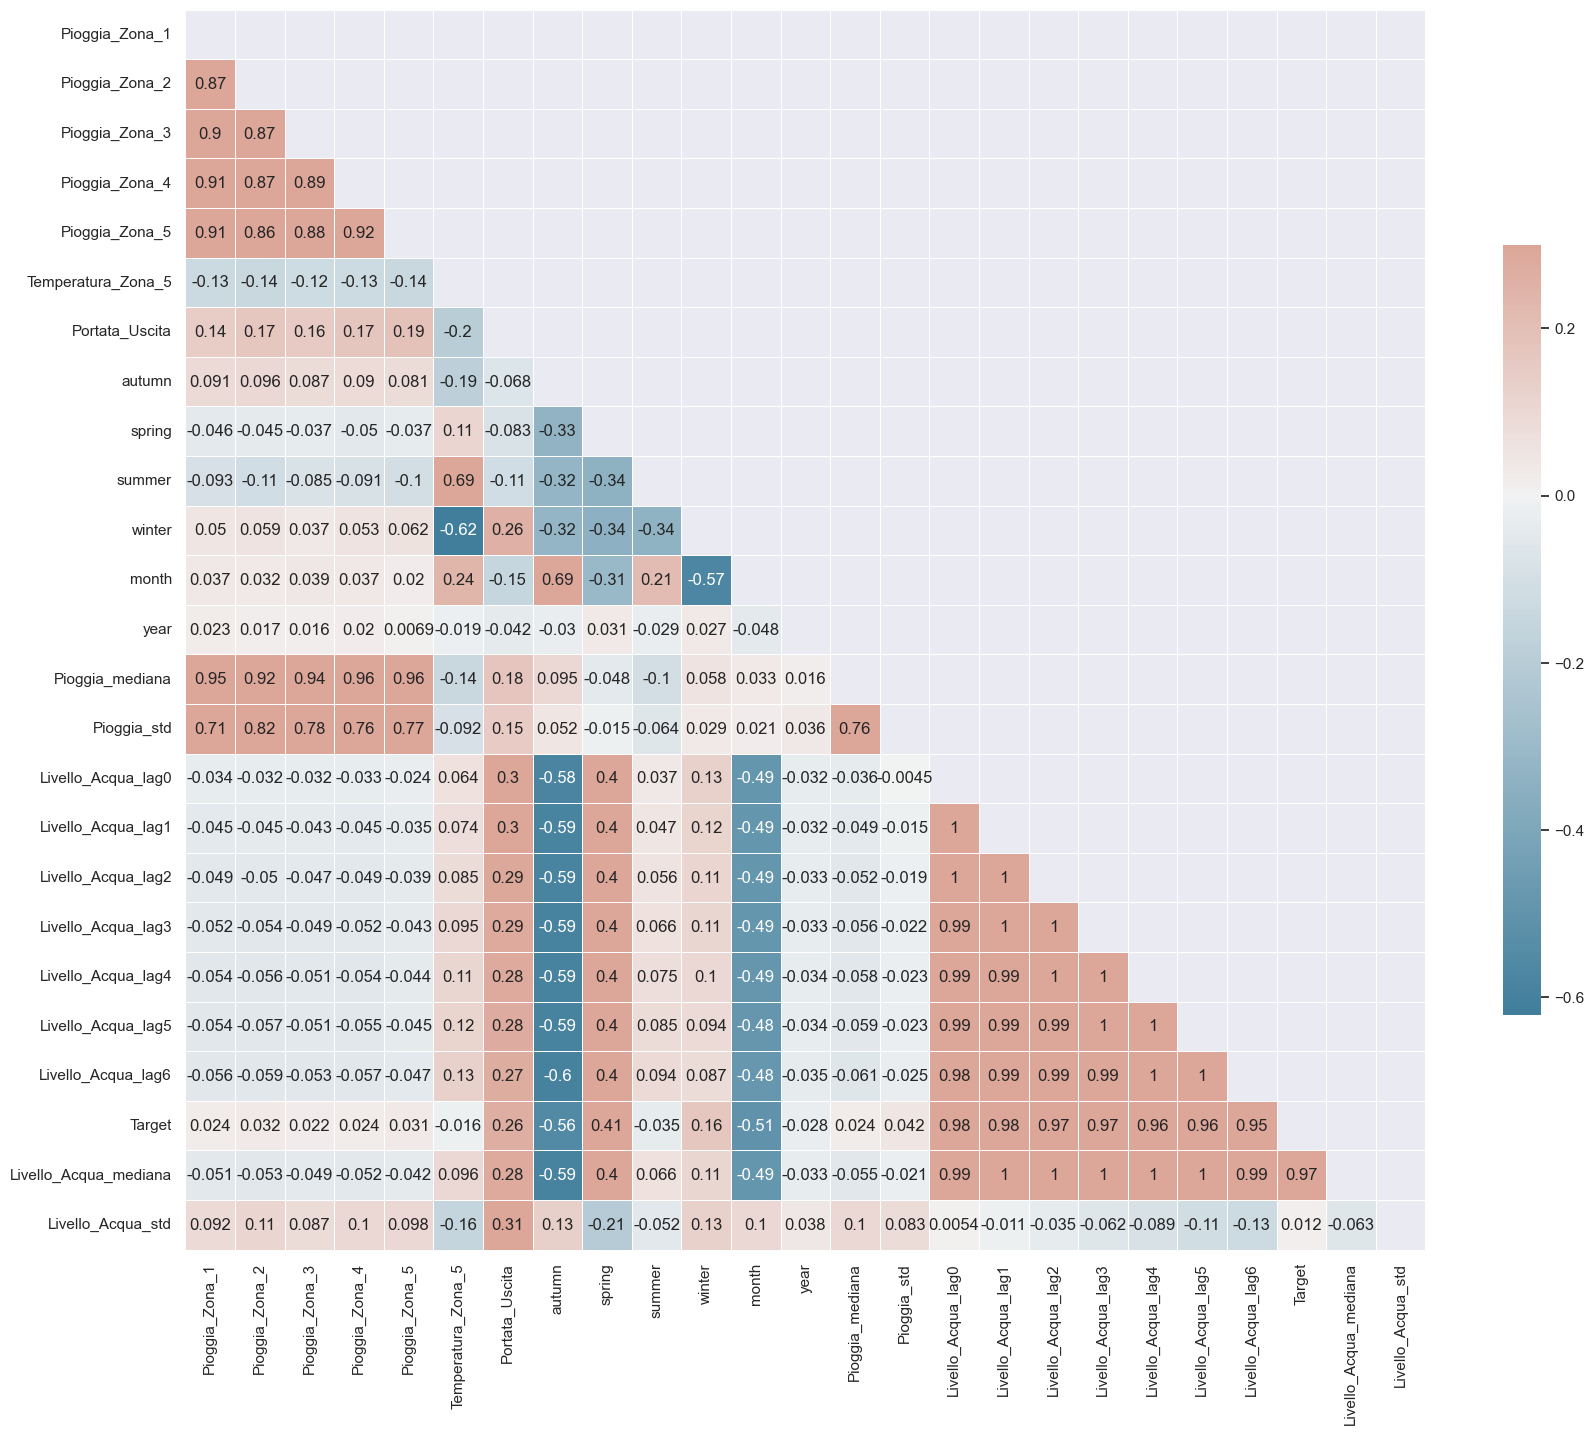

In [35]:
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(df_xg.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df_xg.corr(), mask = mask, annot=True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

Utilizzio come test l'ultimo anno inteso come 365 giorni, e come train tutto il resto.

In [36]:
Train = df_xg.iloc[:int(df_xg.shape[0]-365)]
Test = df_xg.iloc[int(df_xg.shape[0]-365):]

In [37]:
Train.tail(1)

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Portata_Uscita,autumn,spring,...,Livello_Acqua_lag0,Livello_Acqua_lag1,Livello_Acqua_lag2,Livello_Acqua_lag3,Livello_Acqua_lag4,Livello_Acqua_lag5,Livello_Acqua_lag6,Target,Livello_Acqua_mediana,Livello_Acqua_std
6012,2019-06-23,0.0,0.0,0.0,0.0,0.0,23.15,0.6,0,0,...,30.66,30.6,30.63,30.63,30.63,30.64,30.66,30.6,30.63,0.020702


In [38]:
Test.tail(1)

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Portata_Uscita,autumn,spring,...,Livello_Acqua_lag0,Livello_Acqua_lag1,Livello_Acqua_lag2,Livello_Acqua_lag3,Livello_Acqua_lag4,Livello_Acqua_lag5,Livello_Acqua_lag6,Target,Livello_Acqua_mediana,Livello_Acqua_std
6377,2020-06-22,0.0,0.0,0.0,0.0,0.0,23.05,0.6,0,0,...,29.86,29.88,29.9,29.92,29.93,29.91,29.92,29.82,29.91,0.024976


Salvataggio dei dati per il training

In [39]:
Train.to_csv('Data/Prepared/train_SL.csv', index=False)
Test.to_csv('Data/Prepared/test_SL.csv', index=False)

# 3) Preprocessing Target 2: **Portata Uscita**.

Per il secondo target, *Portata_Uscita*, si è deciso di processare i dati in un modo differente.


### 3.2) Supervised Learning Preprocessing 

Anche qui si utilizza per il preprocessing il dataset pulito nella fase di missing analysis.

In [40]:
df_PU_SL = df_clean.copy()
df_PU_SL.shape

(6024, 10)

In [41]:
df_PU_SL.columns

Index(['Data', 'Pioggia_Zona_1', 'Pioggia_Zona_2', 'Pioggia_Zona_3',
       'Pioggia_Zona_4', 'Pioggia_Zona_5', 'Temperatura_Zona_5',
       'Livello_Acqua', 'Portata_Uscita', 'season'],
      dtype='object')

Si aggiungono informazioni di tipo temporale:
- season (4 variabili dummy);
- year;
- month;
- day;
- week.


In [42]:
df_PU_SL['Data'] = pd.to_datetime(df_PU_SL['Data'], format="%d/%m/%Y")
df_PU_SL['season'] = df_PU_SL.Data.map(season_of_date)

c:\Users\nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\base.py:880: UserWarning: Parsing '21/03/2004' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  new_values = map_f(values, mapper)
c:\Users\nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\base.py:880: UserWarning: Parsing '20/06/2004' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  new_values = map_f(values, mapper)
c:\Users\nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\base.py:880: UserWarning: Parsing '21/06/2004' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  new_values = map_f(values, mapper)
c:\Users\nabil\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\base.py:880: UserWarning: Parsing '22/09/2004' in DD/MM/YYYY format. Provide format or specify infer_datetime_f

In [43]:
seas = pd.get_dummies(df_PU_SL['season'])
df_PU_SL = pd.concat([df_PU_SL,seas], axis=1)
df_PU_SL.drop('season', axis=1, inplace=True)

In [44]:
df_PU_SL['year'] = df_PU_SL.Data.dt.year
df_PU_SL['month'] = df_PU_SL.Data.dt.month
df_PU_SL['day_in_year'] = df_PU_SL.Data.dt.dayofyear
df_PU_SL['week_in_year'] = df_PU_SL.Data.dt.isocalendar().week.astype(int)

Si analizza la singola variabile temperatura utile per la predizione.

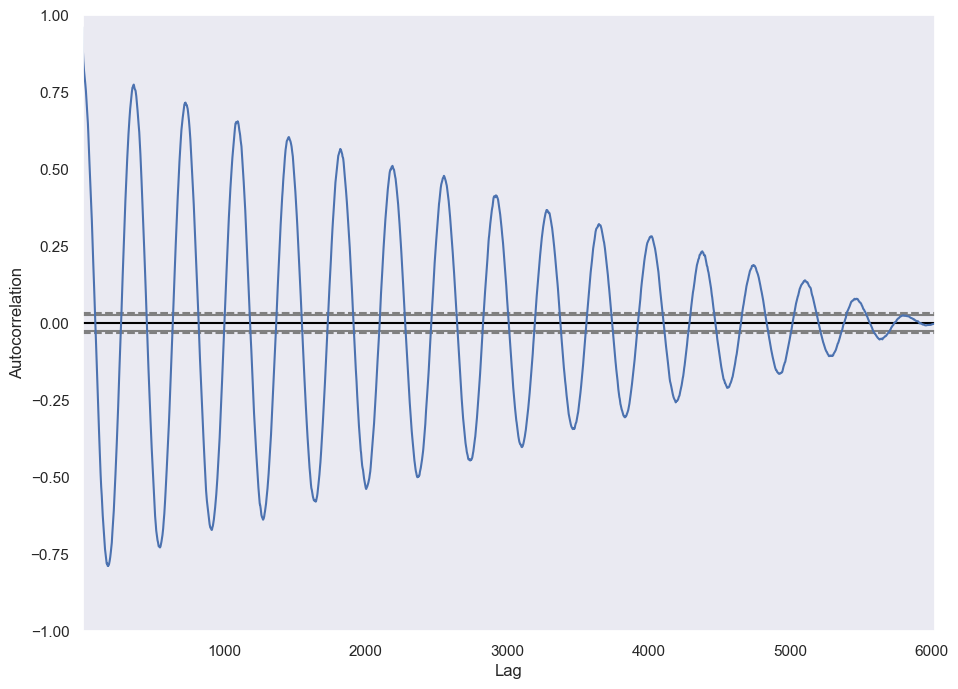

In [45]:
pd.plotting.autocorrelation_plot(df_PU_SL.Temperatura_Zona_5)
plt.show()

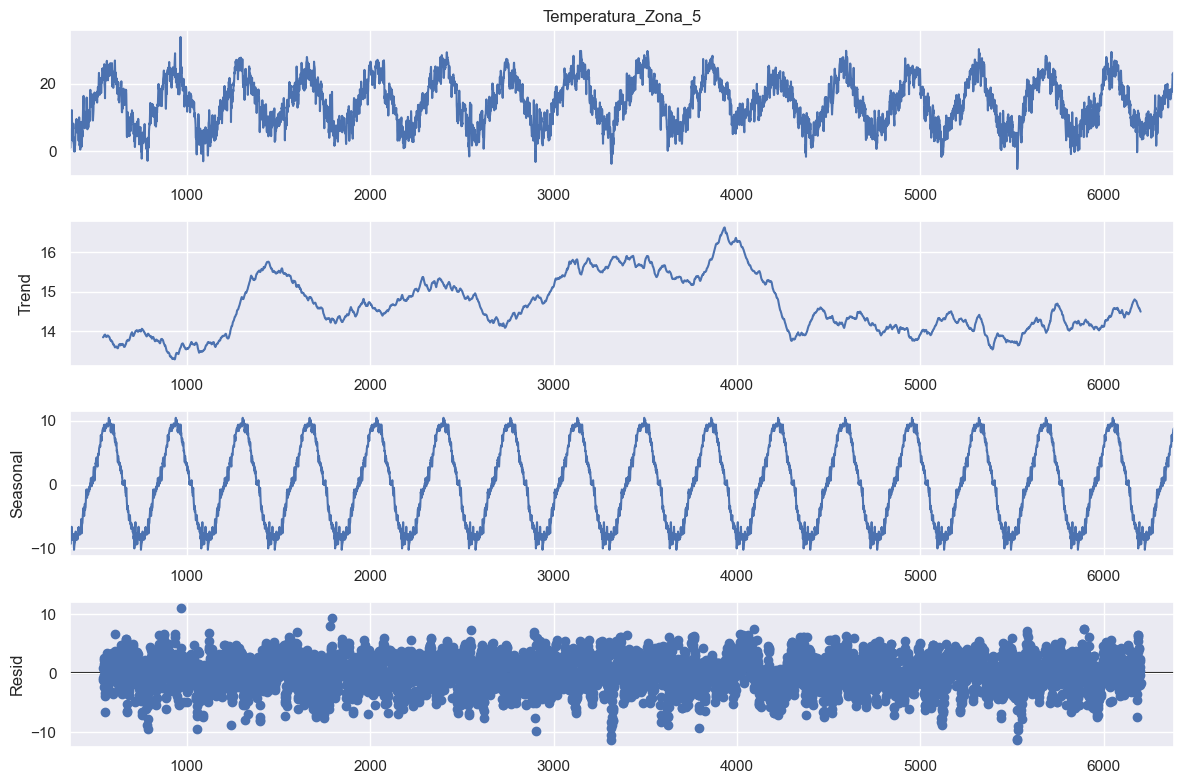

In [46]:
decompose_result = seasonal_decompose(df_PU_SL.Temperatura_Zona_5, period=365)
plt.rcParams['figure.figsize'] = (12, 8) 
fig = decompose_result.plot()

Si scompone l'unica variabile di temperatura in 3 componenti:
- trend-ciclo;
- stagionale;
- irregolare.

Queste vengono successivamente aggiunte al dataset.

In [47]:
df_PU_SL['Temperatura_Trend'] = decompose_result.trend
df_PU_SL['Temperatura_Season'] = decompose_result.seasonal
df_PU_SL['Temperatura_Resid'] = decompose_result.resid

In seguito si creano altre variabili che calcolano la differenza tra il valore corrente e il corrispettivo del giorno t-i con i da 1 a 6. Questo calcolo viene fatto per le variabili di pioggia e target.

<AxesSubplot:>

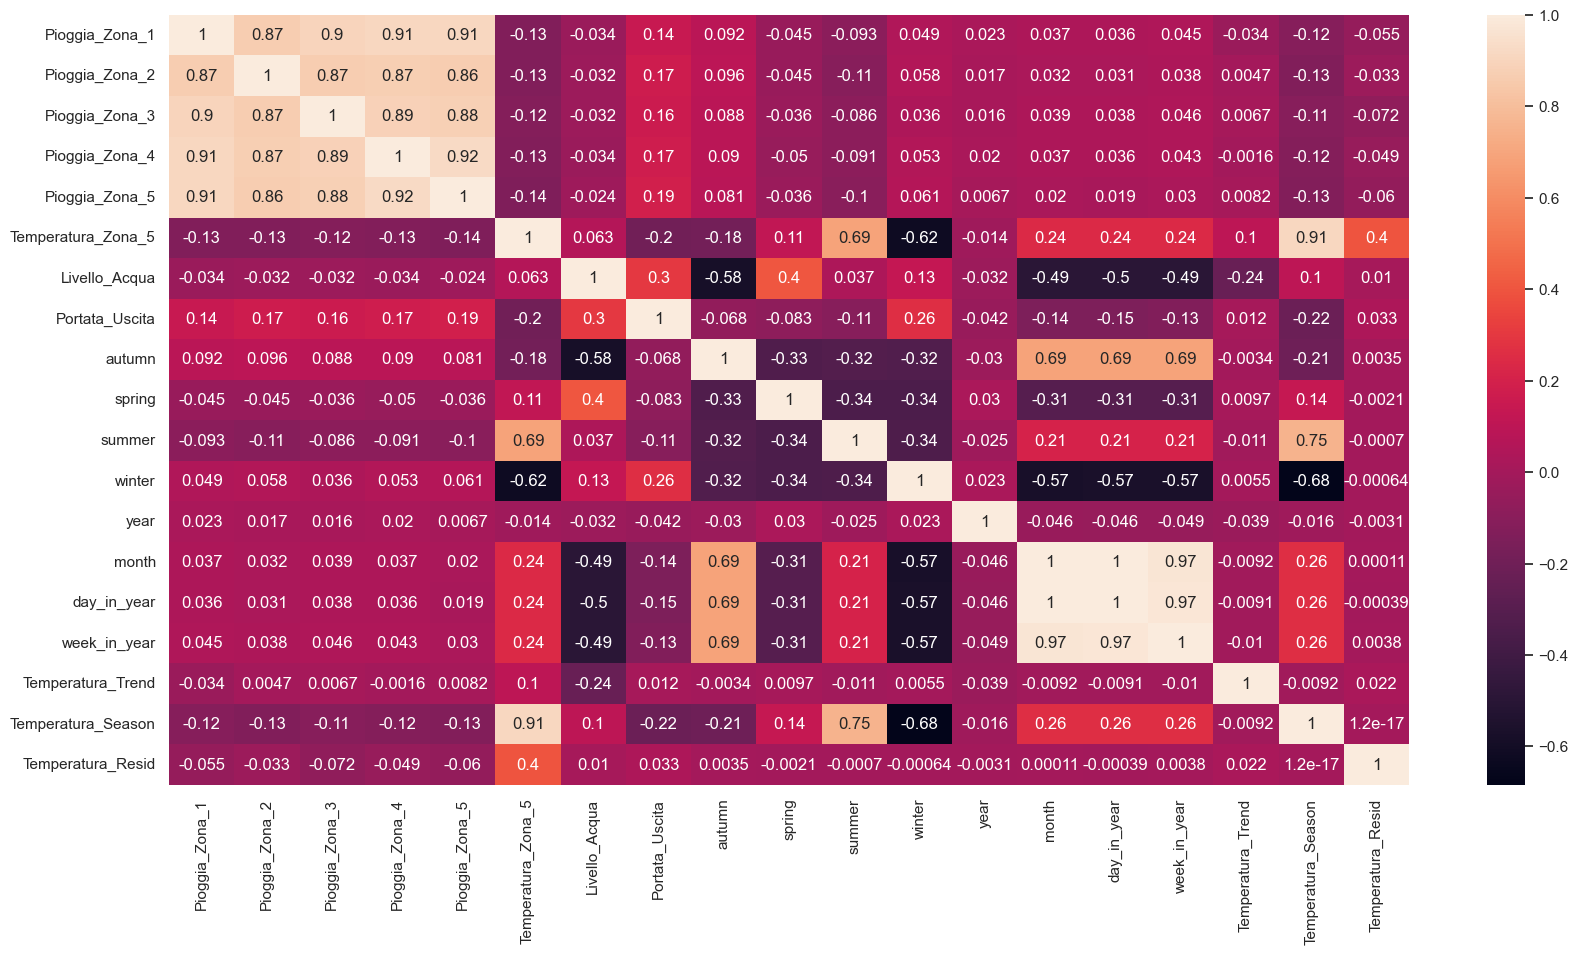

In [48]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_PU_SL.corr(), annot = True)

In [49]:
for i in range(1, 7):
    df_PU_SL[f'Pioggia_Zona_1_diff_{i}'] = df_PU_SL['Pioggia_Zona_1'].diff(periods = i)
    df_PU_SL[f'Pioggia_Zona_2_diff_{i}'] = df_PU_SL['Pioggia_Zona_2'].diff(periods = i)
    df_PU_SL[f'Pioggia_Zona_3_diff_{i}'] = df_PU_SL['Pioggia_Zona_3'].diff(periods = i)
    df_PU_SL[f'Pioggia_Zona_4_diff_{i}'] = df_PU_SL['Pioggia_Zona_4'].diff(periods = i)
    df_PU_SL[f'Pioggia_Zona_5_diff_{i}'] = df_PU_SL['Pioggia_Zona_5'].diff(periods = i)
    df_PU_SL[f'Livello_Acqua_diff_{i}'] = df_PU_SL['Livello_Acqua'].diff(periods = i)
    df_PU_SL[f'Portata_Uscita_diff_{i}'] = df_PU_SL['Portata_Uscita'].diff(periods = i)

Vngono aggiunte le varibili shiftate:
- Temperatura_Trend shift 1;
- Temperatura_Season shift 1;
- Temperatura_Resid shift 1;
- Livello_Acqua shift 30;
- Portata_Uscita shift 30.

In [50]:
df_PU_SL[['Temperatura_Trend_shifted','Temperatura_Season_shifted','Temperatura_Resid_shifted']] = df_PU_SL[['Temperatura_Trend','Temperatura_Season',
                                                                                                           'Temperatura_Resid']].shift(1)

df_PU_SL[['Livello_Acqua_shifted', 'Portata_Uscita_shifted']] = df_PU_SL[['Livello_Acqua', 'Portata_Uscita']].shift(30)

Infine si definisce la variabile Target, ossia la portata d'uscita tra 7 giorni.

In [51]:
df_PU_SL['Target']=df_PU_SL['Portata_Uscita'].shift(-7)
df_PU_SL.drop('Portata_Uscita', axis=1, inplace=True)
df_PU_SL.dropna(axis=0, inplace=True)

In [52]:
df_PU_SL.head(5)

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,autumn,spring,...,Pioggia_Zona_4_diff_6,Pioggia_Zona_5_diff_6,Livello_Acqua_diff_6,Portata_Uscita_diff_6,Temperatura_Trend_shifted,Temperatura_Season_shifted,Temperatura_Resid_shifted,Livello_Acqua_shifted,Portata_Uscita_shifted,Target
544,2004-07-03,0.0,0.0,0.0,0.0,0.0,21.15,30.83,0,0,...,0.0,0.0,-0.06,0.0,13.853151,8.841953,0.804897,31.02,2.0,1.5
545,2004-07-04,0.0,0.0,0.0,0.0,0.0,21.65,30.81,0,0,...,0.0,0.0,-0.07,0.0,13.852329,8.507972,-1.210300,31.02,2.0,1.5
546,2004-07-05,0.0,0.0,0.0,0.0,0.0,21.95,30.80,0,0,...,0.0,0.0,-0.07,0.0,13.857397,8.576747,-0.784144,31.02,2.0,2.0
547,2004-07-06,0.0,0.0,0.0,0.0,0.0,23.00,30.78,0,0,...,0.0,0.0,-0.08,0.4,13.863973,8.485472,-0.399444,31.02,2.0,2.0
548,2004-07-07,0.0,0.0,0.0,0.0,0.0,24.65,30.75,0,0,...,0.0,0.0,-0.10,0.4,13.875342,8.662543,0.462114,31.02,2.3,2.0


In [53]:
df_PU_SL.describe()

,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,autumn,spring,summer,...,Pioggia_Zona_4_diff_6,Pioggia_Zona_5_diff_6,Livello_Acqua_diff_6,Portata_Uscita_diff_6,Temperatura_Trend_shifted,Temperatura_Season_shifted,Temperatura_Resid_shifted,Livello_Acqua_shifted,Portata_Uscita_shifted,Target
count,5659.000000,5659.00000,5659.00000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,...,5659.000000,5.659000e+03,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000,5659.000000
mean,2.474854,3.36024,2.70023,2.676091,3.150345,14.715824,28.444838,0.251635,0.243859,0.263651,...,0.000035,7.219687e-18,-0.001670,0.010972,14.639509,0.069596,0.010112,28.454004,2.642583,2.705897
std,6.710728,9.00029,7.29105,7.734809,8.120869,6.971844,2.198890,0.433991,0.429447,0.440651,...,10.751719,1.124621e+01,0.404055,3.958555,0.713202,6.366633,2.750078,2.205595,3.867663,3.946079
min,0.000000,0.00000,0.00000,0.000000,0.000000,-5.350000,22.530000,0.000000,0.000000,0.000000,...,-113.600000,-8.620000e+01,-1.230000,-67.450000,13.294658,-10.251994,-11.371504,22.530000,0.450000,0.450000
25%,0.000000,0.00000,0.00000,0.000000,0.000000,9.200000,26.755000,0.000000,0.000000,0.000000,...,-0.200000,-4.000000e-01,-0.225000,0.000000,14.083356,-6.314313,-1.877265,26.755000,0.600000,0.600000
50%,0.000000,0.00000,0.00000,0.000000,0.000000,14.700000,29.060000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,-0.060000,0.000000,14.473288,0.101619,0.159520,29.070000,1.500000,1.500000
75%,0.800000,1.40000,1.20000,0.400000,1.200000,20.450000,30.290000,1.000000,0.000000,1.000000,...,0.200000,4.000000e-01,0.050000,0.000000,15.254178,6.136134,1.920699,30.310000,3.000000,3.000000
max,80.600000,110.00000,120.20000,113.600000,88.400000,34.000000,31.760000,1.000000,1.000000,1.000000,...,113.600000,8.840000e+01,5.500000,64.680000,16.625890,10.479033,10.995710,31.760000,74.650000,74.650000


Si effettua lo split dei dati in train e test (80-20).

In [54]:
n = len(df_PU_SL)
f = 0.8
train_PU_SL = df_PU_SL[:int(n*f)]
test_PU_SL = df_PU_SL[int(n*f):]

In [55]:
train_PU_SL.head(1)

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,autumn,spring,...,Pioggia_Zona_4_diff_6,Pioggia_Zona_5_diff_6,Livello_Acqua_diff_6,Portata_Uscita_diff_6,Temperatura_Trend_shifted,Temperatura_Season_shifted,Temperatura_Resid_shifted,Livello_Acqua_shifted,Portata_Uscita_shifted,Target
544,2004-07-03,0.0,0.0,0.0,0.0,0.0,21.15,30.83,0,0,...,0.0,0.0,-0.06,0.0,13.853151,8.841953,0.804897,31.02,2.0,1.5


In [56]:
train_PU_SL.tail(1)

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,autumn,spring,...,Pioggia_Zona_4_diff_6,Pioggia_Zona_5_diff_6,Livello_Acqua_diff_6,Portata_Uscita_diff_6,Temperatura_Trend_shifted,Temperatura_Season_shifted,Temperatura_Resid_shifted,Livello_Acqua_shifted,Portata_Uscita_shifted,Target
5070,2016-11-23,1.8,2.4,1.4,1.2,2.4,13.3,27.47,1,0,...,-40.6,-36.2,1.48,0.0,14.023014,-5.201412,4.828398,25.25,2.0,0.6


In [57]:
test_PU_SL.head(1)

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,autumn,spring,...,Pioggia_Zona_4_diff_6,Pioggia_Zona_5_diff_6,Livello_Acqua_diff_6,Portata_Uscita_diff_6,Temperatura_Trend_shifted,Temperatura_Season_shifted,Temperatura_Resid_shifted,Livello_Acqua_shifted,Portata_Uscita_shifted,Target
5071,2016-11-24,4.2,8.6,5.4,9.0,7.6,11.1,27.5,1,0,...,-34.4,-27.0,1.5,0.0,14.036849,-4.804914,4.068064,25.22,2.0,0.6


In [58]:
test_PU_SL.tail(1)

,Data,Pioggia_Zona_1,Pioggia_Zona_2,Pioggia_Zona_3,Pioggia_Zona_4,Pioggia_Zona_5,Temperatura_Zona_5,Livello_Acqua,autumn,spring,...,Pioggia_Zona_4_diff_6,Pioggia_Zona_5_diff_6,Livello_Acqua_diff_6,Portata_Uscita_diff_6,Temperatura_Trend_shifted,Temperatura_Season_shifted,Temperatura_Resid_shifted,Livello_Acqua_shifted,Portata_Uscita_shifted,Target
6202,2019-12-30,0.2,0.0,0.0,0.0,0.0,4.3,29.04,0,0,...,0.0,-0.2,-0.76,-13.76,14.506986,-8.280539,-2.026448,29.26,10.17,7.2


In [59]:
train_PU_SL.to_csv('Data/Prepared/train_PU_SL.csv', index=False)
test_PU_SL.to_csv('Data/Prepared/test_PU_SL.csv', index=False)